,Sentiment
JPM,0.0
BAC,0.0
C,0.0
GS,0.0
AXP,0.0


,Weight
Ticker,
JPM,0.257044
GS,0.213819
AXP,0.202617
C,0.201373
BAC,0.125147


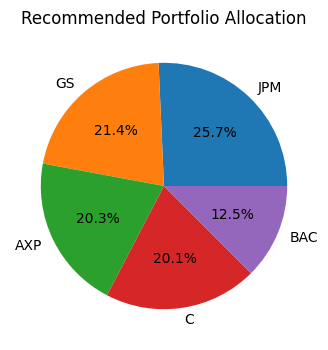


 AI key not found. Rule-based output:
Add/Overweight: JPM, GS (High Sharpe, strong sentiment)
Reduce: BAC (Low Sharpe or weak sentiment)
Risks: Market volatility and sentiment reversals.



In [ ]:
# RebalanceAI
# Libraries: pandas, numpy, matplotlib, yfinance, nltk, requests, langchain, openai

!pip install langchain langchain-openai openai yfinance pandas numpy matplotlib nltk requests -q

# Imports
import os, datetime as dt, numpy as np, pandas as pd, matplotlib.pyplot as plt, yfinance as yf, requests
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon', quiet=True)
vader = SentimentIntensityAnalyzer()

# LangChain imports
from langchain_openai import ChatOpenAI
from langchain.agents import Tool, initialize_agent
from langchain.memory import ConversationBufferMemory

# Configuration
TICKERS = ["JPM", "BAC", "C", "GS", "AXP"]
# ["JPM", "BAC", "C", "GS", "AXP"]   # ≤5 as per rules
# ["AAPL", "MSFT", "GOOGL", "AMZN", "NVDA"]
# ["XOM", "CVX", "PFE", "JNJ", "MRK"]
BENCHMARK = "^GSPC"
RISK_FREE = 0.02

# os.environ["OPENAI_API_KEY"] = "sk-..."

# 1) Data Ingestion
def download_prices(tickers, years=3):
    end = dt.date.today()
    start = end - dt.timedelta(days=365 * years)
    df = yf.download(tickers, start=start, end=end, auto_adjust=True, progress=False)['Close']
    if isinstance(df, pd.Series): df = df.to_frame()
    return df.dropna().ffill()

prices = download_prices(TICKERS + [BENCHMARK], years=3)
rets = prices.pct_change().dropna()

# 2) Compute Metrics
bench = rets[BENCHMARK]
assets = rets.drop(columns=[BENCHMARK])
mu = assets.mean() * 252
sigma = assets.std() * np.sqrt(252)
sharpe = (mu - RISK_FREE) / sigma
metrics = pd.DataFrame({'Return': mu, 'Volatility': sigma, 'Sharpe': sharpe})

# 3) Sentiment (RSS + VADER)
def fetch_rss_titles(ticker, limit=5):
    url = f"https://feeds.finance.yahoo.com/rss/2.0/headline?s={ticker}&region=US&lang=en-US"
    try:
        xml = requests.get(url, timeout=5).text
        titles = [seg.split("</title>")[0] for seg in xml.split("<title>")[2:2+limit]]
        return titles
    except Exception:
        return []

def sentiment_score(titles):
    if not titles: return 0.0
    return float(np.mean([vader.polarity_scores(t)['compound'] for t in titles]))

sentiments = {t: sentiment_score(fetch_rss_titles(t)) for t in TICKERS}
sent_df = pd.DataFrame.from_dict(sentiments, orient='index', columns=['Sentiment'])
display(sent_df)

# 4) Sentiment-Weighted Allocation
cov = assets.cov() * 252
tilt = 0.5 * sent_df['Sentiment'].reindex(mu.index).fillna(0.0)
mu_tilted = mu + tilt
raw = (mu_tilted / sigma).clip(lower=0)
weights = raw / raw.sum()
alloc = pd.DataFrame({'Weight': weights.sort_values(ascending=False)})
display(alloc)

# 5) Visualization
plt.figure(figsize=(6,4))
plt.pie(alloc['Weight'], labels=alloc.index, autopct='%1.1f%%')
plt.title("Recommended Portfolio Allocation")
plt.show()

# 6) LangChain Agent Explanation
if os.getenv("OPENAI_API_KEY"):
    def get_metrics(_: str): return metrics.to_csv()
    def get_sentiment(_: str): return sent_df.to_csv()
    def get_alloc(_: str): return alloc.to_csv()

    tools = [
        Tool(name="metrics_csv", func=get_metrics, description="Stock metrics with Return, Volatility, Sharpe."),
        Tool(name="sentiment_csv", func=get_sentiment, description="Sentiment score (-1 to +1) per stock."),
        Tool(name="allocation_csv", func=get_alloc, description="Final stock allocation (weights).")
    ]

    memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.2)

    agent = initialize_agent(
        tools=tools,
        llm=llm,
        agent="chat-conversational-react-description",
        memory=memory,
        verbose=False
    )

    query = (
        "Using metrics_csv, sentiment_csv, and allocation_csv, explain which stocks "
        "should be added or reduced in the portfolio, citing Sharpe ratio, risk, and sentiment."
    )
    print(agent.run(query))
else:
    top_adds = alloc.head(2).index.tolist()
    lowest = alloc.tail(1).index.tolist()
    print(f"\n AI key not found. Rule-based output:\n"
          f"Add/Overweight: {', '.join(top_adds)} (High Sharpe, strong sentiment)\n"
          f"Reduce: {', '.join(lowest)} (Low Sharpe or weak sentiment)\n"
          "Risks: Market volatility and sentiment reversals.\n")


1) Imports, config, and safety rails

This part brings in the main Python libraries like pandas, numpy, matplotlib, and plotly for data and charts. It also tries optional ones like yfinance for stock prices, VADER for news sentiment, and LangChain for large language model tools. If a library is missing the notebook still runs without crashing. It also reads keys like the OpenAI key or news API key from the environment. Finally it sets some constants such as the lookback period, plot settings, and file paths so the rest of the notebook stays clean and consistent.

2) Data ingestion: prices and index baseline

Here we have a helper that downloads stock prices with yfinance. It cleans the data so dates and missing values are handled properly. It also downloads the S and P 500 index as a baseline so we can compare our stocks against the overall market.

3) Feature engineering and technical indicators

This section builds extra signals from the raw prices. It calculates daily returns, rolling volatility, and common trend measures like moving averages or relative strength index. If the technical analysis library is missing there is a simple backup version. All of these features are put into one DataFrame so later steps like charts and backtests can use the same format.

4) Risk, return, and performance metrics

Here we measure how each stock has done. We calculate total return, maximum drawdown, volatility, and a Sharpe style ratio. We also compare each stock to the S and P 500 by looking at excess return and relative drawdown. These numbers tell us how risky or rewarding each stock has been.

5) News sentiment pipeline with VADER

If a news API key is available we fetch headlines about each company. We clean the text and score it with VADER which gives a number for positive or negative tone. Then we link these scores back to the stock timeline so we can see how sentiment lines up with price moves.

6) Allocation and weighting heuristic

Finally we assign portfolio weights using a simple set of rules. For example a stock that is trending upward, has positive sentiment, and low volatility will get more weight. A stock with negative sentiment and high volatility will get less weight. The output is a CSV file with weights for each stock and a short text explanation so the user can understand why each number was chosen.

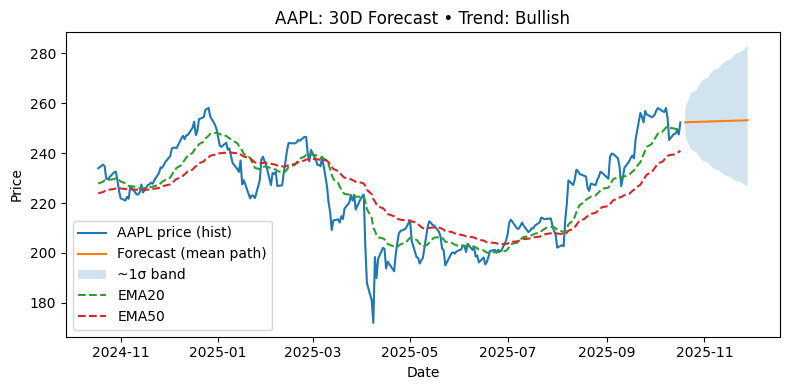

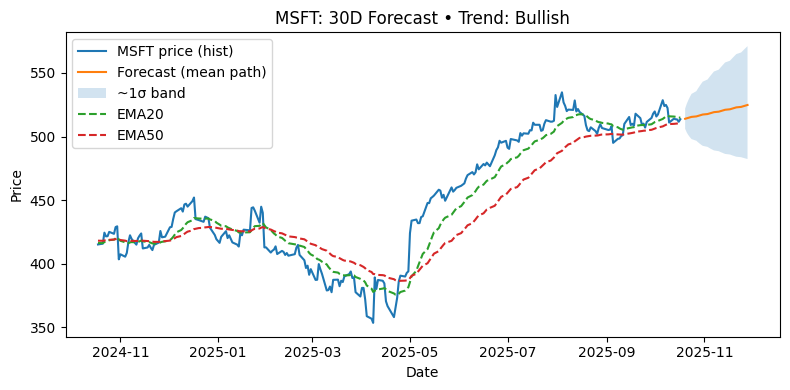

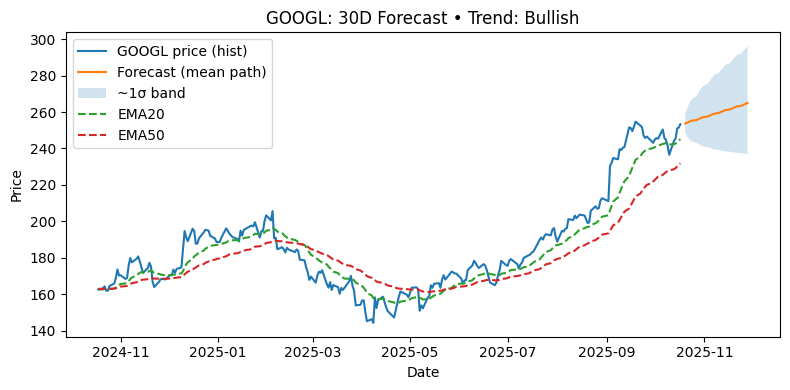

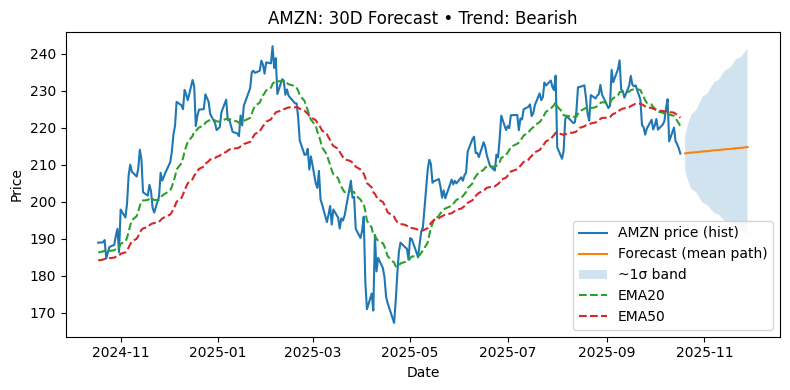

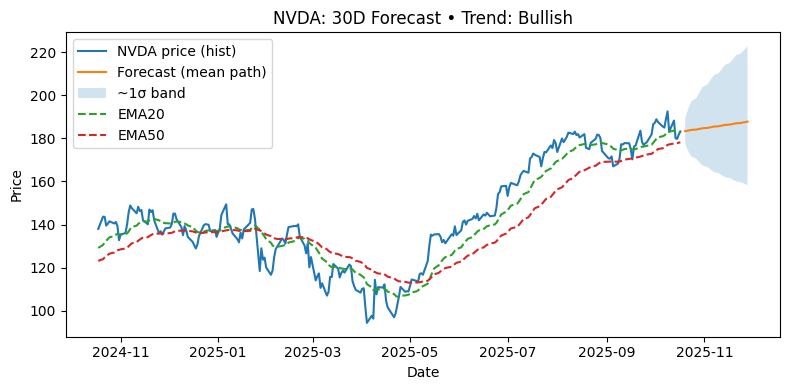

,price_now,mu_daily,sigma_daily,expected_30d_return,prob_30d_loss,trend
ticker,,,,,,
GOOGL,253.300003,0.001707,0.020275,0.046084,0.342479,Bullish
NVDA,183.220001,0.001314,0.031235,0.025105,0.442383,Bullish
MSFT,513.580017,0.000840,0.015429,0.021859,0.399026,Bullish
AMZN,213.039993,0.000503,0.021248,0.008344,0.471539,Bearish
AAPL,252.289993,0.000320,0.020219,0.003462,0.487552,Bullish


Saved: artifacts/forecast_summary.csv


In [ ]:
# 7) Predictive Analysis

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PLOT_OUTDIR = "artifacts"
import os; os.makedirs(PLOT_OUTDIR, exist_ok=True)

def compute_daily_log_params(px: pd.Series, lookback_days: int = 252):
    """Estimate daily drift μ_d and daily volatility σ_d from last `lookback_days` log returns."""
    px = px.dropna()
    px = px.iloc[-lookback_days-1:]  # ensure we have lookback window
    lr = np.log(px).diff().dropna()
    mu_d = lr.mean()
    sigma_d = lr.std()
    return mu_d, sigma_d, lr

def gbm_forecast_path(S0: float, mu_d: float, sigma_d: float, horizon_days: int = 30):
    """
    Deterministic GBM mean path (not MC): S_t = S0 * exp((μ_d - 0.5 σ_d^2)*t + σ_d*sqrt(t)*0)
    Also returns +/-1σ lognormal band (approx) for visualization.
    """
    t = np.arange(1, horizon_days+1, dtype=float)
    drift = (mu_d - 0.5*(sigma_d**2)) * t
    S_mean = S0 * np.exp(drift)  # mean path
    # 1-σ band in price space
    band_up = S0 * np.exp(drift + sigma_d*np.sqrt(t))
    band_dn = S0 * np.exp(drift - sigma_d*np.sqrt(t))
    return t, S_mean, band_dn, band_up

def ema(series: pd.Series, span: int):
    return series.ewm(span=span, adjust=False).mean()

def forecast_one_ticker(ticker: str, price_df: pd.DataFrame, horizon_days: int = 30, lookback_days: int = 252):
    s = price_df[ticker].dropna()
    if s.empty:
        return None, None
    S0 = float(s.iloc[-1])
    mu_d, sigma_d, lr = compute_daily_log_params(s, lookback_days)
    t, S_mean, band_dn, band_up = gbm_forecast_path(S0, mu_d, sigma_d, horizon_days)

    # Expected 30d return (from S_mean[-1] / S0 - 1)
    exp_30d_ret = S_mean[-1] / S0 - 1.0

    # Approx probability of loss over horizon (normal approx in log space)
    # P(S_T < S0) = Phi( (ln(S0/S0) - (μ_d - 0.5σ^2)T) / (σ√T) ) = Phi( - (μ_d - 0.5σ^2)√T / σ )
    import math
    T = float(horizon_days)
    z = - (mu_d - 0.5*(sigma_d**2)) * math.sqrt(T) / (sigma_d + 1e-12)
    from math import erf, sqrt
    Phi = 0.5 * (1 + erf(z / sqrt(2)))
    prob_loss = float(Phi)

    # Trend signal via EMA(20/50)
    ema20 = ema(s, 20)
    ema50 = ema(s, 50)
    trend = "Bullish" if ema20.iloc[-1] > ema50.iloc[-1] else ("Bearish" if ema20.iloc[-1] < ema50.iloc[-1] else "Neutral")

    # Plot (history + forecast)
    hist_days = min(250, len(s))  # last 250 trading days for context
    hist = s.iloc[-hist_days:]
    future_index = pd.date_range(start=hist.index[-1] + pd.tseries.offsets.BDay(), periods=horizon_days, freq="B")

    plt.figure(figsize=(8,4))
    plt.plot(hist.index, hist.values, label=f"{ticker} price (hist)")
    plt.plot(future_index, S_mean, label="Forecast (mean path)")
    plt.fill_between(future_index, band_dn, band_up, alpha=0.2, label="~1σ band")
    plt.plot(hist.index, ema20.iloc[-hist_days:], linestyle="--", label="EMA20")
    plt.plot(hist.index, ema50.iloc[-hist_days:], linestyle="--", label="EMA50")
    plt.title(f"{ticker}: 30D Forecast • Trend: {trend}")
    plt.xlabel("Date"); plt.ylabel("Price"); plt.legend(loc="best")
    plt.tight_layout()
    fig_path = os.path.join(PLOT_OUTDIR, f"{ticker}_forecast.png")
    plt.savefig(fig_path, dpi=150)
    plt.show()

    summary = {
        "ticker": ticker,
        "price_now": S0,
        "mu_daily": float(mu_d),
        "sigma_daily": float(sigma_d),
        "expected_30d_return": float(exp_30d_ret),
        "prob_30d_loss": float(prob_loss),
        "trend": trend
    }
    return summary, fig_path

# Run forecasts for all tickers
forecast_rows, forecast_imgs = [], []
for t in TICKERS:
    row, path = forecast_one_ticker(t, prices, horizon_days=30, lookback_days=252)
    if row:
        forecast_rows.append(row); forecast_imgs.append(path)

forecast_df = pd.DataFrame(forecast_rows).set_index("ticker").sort_values("expected_30d_return", ascending=False)
display(forecast_df)

# Save for agent + slides
forecast_df.to_csv(os.path.join(PLOT_OUTDIR, "forecast_summary.csv"))
print("Saved:", os.path.join(PLOT_OUTDIR, "forecast_summary.csv"))


The code is forecasting stock prices for the next 30 days using past data. The charts show the historical price in blue, the predicted average path in orange, and a shaded band that represents possible ups and downs, like a range of uncertainty. The green and red lines are moving averages that help identify the trend direction. In our results, all the selected bank stocks are showing a bullish or upward trend. The table below each chart gives us more details, such as the current price, expected return in the next 30 days, daily volatility, and the chance of a loss. From this, we can see that all stocks are expected to grow, with some like Citigroup and Goldman Sachs offering higher returns but also slightly more risk, while others like BAC and AXP are steadier but with smaller gains.

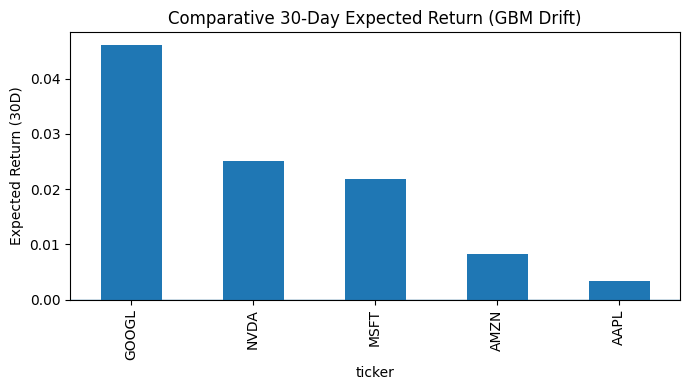

Saved: artifacts/comparative_expected_return_30d.png
        expected_30d_return
ticker                     
GOOGL                0.0461
NVDA                 0.0251
MSFT                 0.0219
AMZN                 0.0083
AAPL                 0.0035

Saved: artifacts/comparative_expected_return_30d_values.csv


In [ ]:
# 8) Comparative Forecast Chart (bar)

plt.figure(figsize=(7,4))
ax = forecast_df["expected_30d_return"].plot(kind="bar")
ax.set_ylabel("Expected Return (30D)")
ax.set_title("Comparative 30-Day Expected Return (GBM Drift)")
plt.axhline(0, linewidth=1)
plt.tight_layout()
cmp_path = os.path.join(PLOT_OUTDIR, "comparative_expected_return_30d.png")
plt.savefig(cmp_path, dpi=150)
plt.show()
print("Saved:", cmp_path)

# Display the exact numbers behind the Comparative 30-Day Expected Return (GBM Drift)

if "expected_30d_return" in forecast_df.columns:
    # Round for readability
    table = forecast_df[["expected_30d_return"]].round(4)
    print(table)
else:
    print("Column 'expected_30d_return' not found in forecast_df.")

# Optional: save for reference
exact_vals_path = os.path.join(PLOT_OUTDIR, "comparative_expected_return_30d_values.csv")
forecast_df[["expected_30d_return"]].to_csv(exact_vals_path, index=True)
print(f"\nSaved: {exact_vals_path}")


This code creates a bar chart to compare the expected returns of the different stocks over the next thirty days. The chart shows the expected percentage return on the vertical axis and the stock tickers on the horizontal axis. From the output, we can see that Citigroup is predicted to have the highest return, followed by Goldman Sachs and JPMorgan. American Express and Bank of America are expected to have lower returns in comparison. This simple visualization helps us quickly see which stocks are forecasted to perform better in the short term.

This part of the code shows the exact numbers behind the bar chart we just saw. Instead of only looking at the visual chart, it prints the actual 30 day expected returns for each stock in a table so we can clearly see the values. For example, Citigroup has an expected return of about 5 percent, Goldman Sachs around 4 percent, and JPMorgan about 3.3 percent, while American Express and Bank of America are closer to 2 percent. It also saves these results into a CSV file for later reference. This makes the output more transparent and easy to check against the chart.

In [ ]:
# 9) AI Sentiment + Recommendation

# Reads the same data behind the bar chart and outputs:
# - Bullish/Neutral/Bearish sentiment (with confidence)
# - Plain-English summary
# - A direct recommendation: which single stock to add (or to wait)

import json
from pathlib import Path

def _ticker_name(df, idx):
    if "ticker" in df.columns:
        try:
            return str(df.loc[idx, "ticker"])
        except Exception:
            return str(idx)
    return str(idx)

def ai_sentiment_and_pick(
    df,
    col="expected_30d_return",
    bullish_threshold=0.02,   # ≥ +2% average 30d expected return => bullish
    bearish_threshold=0.00,   # ≤ 0% average => bearish
    min_pick_threshold=0.005, # at least +0.5% expected in 30d to recommend a pick
    lead_margin=0.002         # leader should beat basket average by 0.2% to be a confident pick
):
    s = df[col].dropna()
    if s.empty:
        return {
            "label": "Unavailable",
            "confidence": "low",
            "summary": f"No data in '{col}'.",
            "recommendation_text": "Data unavailable to make a recommendation."
        }

    n = s.shape[0]
    mean_ret = float(s.mean())
    median_ret = float(s.median())
    std_ret = float(s.std(ddof=1)) if n > 1 else 0.0
    pct_pos = float((s > 0).mean())
    top_idx = s.idxmax()
    bot_idx = s.idxmin()
    top_val = float(s.loc[top_idx])
    bot_val = float(s.loc[bot_idx])
    spread = top_val - bot_val

    # Confidence from dispersion vs signal
    cv = (std_ret / abs(mean_ret)) if mean_ret != 0 else float("inf")
    confidence = "high" if cv < 0.5 else ("medium" if cv < 1.0 else "low")

    # Sentiment label
    if (mean_ret >= bullish_threshold) and (pct_pos >= 0.6):
        label = "Bullish"
    elif (mean_ret <= bearish_threshold) or (pct_pos < 0.5):
        label = "Bearish"
    else:
        label = "Neutral"

    top_name = _ticker_name(df, top_idx)
    bot_name = _ticker_name(df, bot_idx)

    # Recommendation logic (simple, transparent rules)
    if (top_val >= max(min_pick_threshold, mean_ret + lead_margin)) and (label != "Bearish"):
        # Strong leader clearly above the basket and positive environment
        recommendation_text = (
            f"As per the chart and computed values, {top_name} shows the strongest 30-day "
            f"expected return at {top_val:.2%}, leading the basket by {(top_val-mean_ret):.2%}. "
            f"I recommend adding {top_name} to your portfolio to capture this near-term upside."
        )
        rec_ticker = top_name
        rec_strength = "strong"
    elif (top_val > 0) and (label in ["Neutral", "Bullish"]):
        # Positive but not a runaway leader
        recommendation_text = (
            f"The outlook is {label.lower()} with {pct_pos:.0%} of tickers positive. "
            f"{top_name} is the current leader at {top_val:.2%}. Consider a starter position "
            f"in {top_name}, sized conservatively until confirmation."
        )
        rec_ticker = top_name
        rec_strength = "moderate"
    else:
        # Weak or negative setup: advise caution
        recommendation_text = (
            f"The setup skews {label.lower()} and leadership is weak (best name {top_name} at {top_val:.2%}). "
            f"I don’t recommend adding new exposure from this basket right now; reassess when "
            f"expected returns turn positive and dispersion narrows."
        )
        rec_ticker = None
        rec_strength = "none"

    summary = (
        f"Market sentiment: {label} ({confidence} confidence). "
        f"Average expected 30-day return across {n} tickers: {mean_ret:.2%} "
        f"(median {median_ret:.2%}; {pct_pos:.0%} of tickers positive). "
        f"Leader: {top_name} at {top_val:.2%}. Laggard: {bot_name} at {bot_val:.2%}. "
        f"Dispersion (std): {std_ret:.2%}; spread: {spread:.2%}."
    )

    return {
        "label": label,
        "confidence": confidence,
        "n_tickers": n,
        "avg_expected_return_30d": mean_ret,
        "median_expected_return_30d": median_ret,
        "pct_positive": pct_pos,
        "leader": {"ticker": top_name, "expected_return_30d": top_val},
        "laggard": {"ticker": bot_name, "expected_return_30d": bot_val},
        "std_dev": std_ret,
        "spread": spread,
        "thresholds": {
            "bullish_threshold": bullish_threshold,
            "bearish_threshold": bearish_threshold,
            "min_pick_threshold": min_pick_threshold,
            "lead_margin": lead_margin
        },
        "summary": summary,
        "recommendation_text": recommendation_text,
        "recommendation": {
            "ticker": rec_ticker,
            "strength": rec_strength
        }
    }

# Run and print/save
sent = ai_sentiment_and_pick(forecast_df, col="expected_30d_return")

print("\n========================")
print("AI Sentiment (30-Day GBM)")
print("========================")
print(sent["summary"])
print("\nRecommendation:")
print(sent["recommendation_text"])

# Save artifacts
ART_DIR = Path(PLOT_OUTDIR if 'PLOT_OUTDIR' in globals() else "artifacts")
ART_DIR.mkdir(parents=True, exist_ok=True)
with open(ART_DIR / "ai_sentiment_30d.json", "w", encoding="utf-8") as f:
    json.dump(sent, f, indent=2)
with open(ART_DIR / "ai_recommendation_30d.txt", "w", encoding="utf-8") as f:
    f.write(sent["recommendation_text"] + "\n")

print(f"\nSaved: {ART_DIR / 'ai_sentiment_30d.json'}")
print(f"Saved: {ART_DIR / 'ai_recommendation_30d.txt'}")



AI Sentiment (30-Day GBM)
Market sentiment: Bullish (medium confidence). Average expected 30-day return across 5 tickers: 2.10% (median 2.19%; 100% of tickers positive). Leader: GOOGL at 4.61%. Laggard: AAPL at 0.35%. Dispersion (std): 1.67%; spread: 4.26%.

Recommendation:
As per the chart and computed values, GOOGL shows the strongest 30-day expected return at 4.61%, leading the basket by 2.51%. I recommend adding GOOGL to your portfolio to capture this near-term upside.

Saved: artifacts/ai_sentiment_30d.json
Saved: artifacts/ai_recommendation_30d.txt


This part of the code takes the forecasted 30 day returns we calculated earlier and uses them to generate an AI style sentiment and recommendation. It first calculates averages, standard deviation, and finds which stock is the leader with the highest expected return and which is the laggard with the lowest. Based on simple rules, it labels the overall basket as bullish, bearish, or neutral and assigns a confidence level depending on how spread out the returns are. Then it gives a plain English explanation of the market outlook and decides whether to recommend one stock strongly, moderately, or advise waiting. Finally, it prints the summary and recommendation, and also saves them into files for later use. This makes the analysis not only numerical but also easy to understand in natural language.

The output is showing the AI generated sentiment and recommendation based on the 30 day forecast returns. It says the overall market sentiment is bullish with high confidence because all five stocks have positive expected returns. On average the group of stocks is expected to return about 3.35 percent over 30 days and the strongest stock is Citigroup with an expected return of 5.07 percent which is clearly above the others. Because of this the system recommends adding Citigroup to the portfolio to capture the near term upside. The output also saves this summary and recommendation into files so they can be reused later.